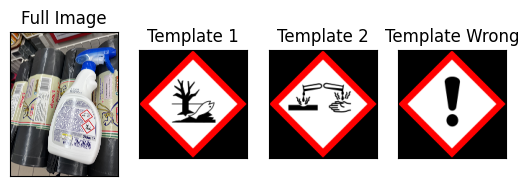

In [3]:
# Trying the tutorial from OpenCV docs https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10

full_img = cv.imread('dataset/test_00000.jpg')
template_1 = cv.imread('templates/GHS_00017.png')
template_2 = cv.imread('templates/GHS_00012.png')
template_wrong = cv.imread('templates/GHS_00014.png')

def get_RGB_from_BGR(img):
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Visualize the iamge and two templates
plt.subplot(141), plt.imshow(get_RGB_from_BGR(full_img))
plt.title('Full Image'), plt.xticks([]), plt.yticks([])
plt.subplot(142), plt.imshow(get_RGB_from_BGR(template_1))
plt.title('Template 1'), plt.xticks([]), plt.yticks([])
plt.subplot(143), plt.imshow(get_RGB_from_BGR(template_2))
plt.title('Template 2'), plt.xticks([]), plt.yticks([])
plt.subplot(144), plt.imshow(get_RGB_from_BGR(template_wrong))
plt.title('Template Wrong'), plt.xticks([]), plt.yticks([])
plt.show()

In [4]:
# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp_img, des_img = sift.detectAndCompute(full_img,None)
kp_t1, des_t1 = sift.detectAndCompute(template_1,None)
kp_t2, des_t2 = sift.detectAndCompute(template_2,None)
kp_t_wrong, des_t_wrong = sift.detectAndCompute(template_wrong,None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)


In [5]:
def try_match_and_draw(template, kp_t, des_t):
    matches = flann.knnMatch(des_t,des_img,k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp_t[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_img[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        h,w = template.shape[:2]
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts,M)
        img2 = cv.polylines(full_img,[np.int32(dst)],True,255,3, cv.LINE_AA)
        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
        match_img = cv.drawMatches(template,kp_t,img2,kp_img,good,None,**draw_params)
        plt.imshow(get_RGB_from_BGR(match_img))
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )

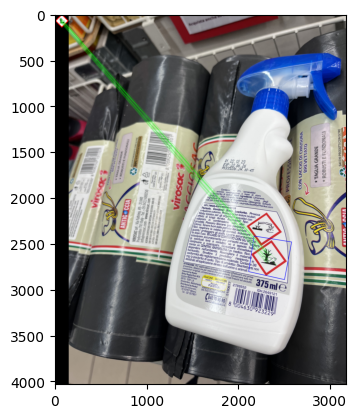

In [6]:
try_match_and_draw(template_1, kp_t1, des_t1)

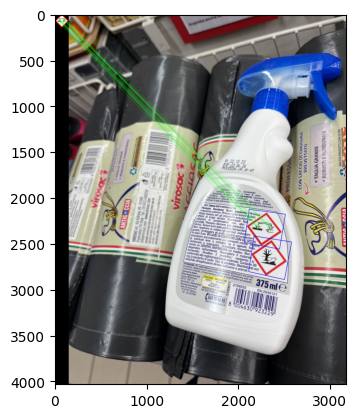

In [7]:
try_match_and_draw(template_2, kp_t2, des_t2)

In [8]:
try_match_and_draw(template_wrong, kp_t_wrong, des_t_wrong)

Not enough matches are found - 0/10


In [9]:
len(kp_img), len(kp_t1), len(kp_t2), len(kp_t_wrong)

(27335, 45, 57, 12)